# AMPS to Zarr 

The Plan (outline)
- read in (some, many?) NetCDF files
- strip unneccessary variables
- squeeze time dimension from non-varying 2D fields
- write (and later append) to zarr in GCS


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

import gcsfs
from tqdm import tqdm
# from tqdm.autonotebook import tqdm
import fsspec

import xarray as xr

xr.set_options(display_style="html");
# xr.show_versions()

### setup runtime parameters

In [5]:
gcsdir = 'gs://ldeo-glaciology'
ampsdir = 'AMPS'
amps_ver = 'WRF_24'

# domain = 'domain_02'
# filepattern = 'wrfout_d02_20191231*'
# pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
# print(pattern)

domain = 'domain_03'
filepattern = 'wrfout_d03_20190930*'
pattern = os.path.join(gcsdir, ampsdir, amps_ver, domain, filepattern)
print(pattern)

gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrfout_d03_20190930*


### list the netcdf files

In [30]:
# fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)
fs = gcsfs.GCSFileSystem(project='pangeo-integration-te-3eea', mode='ab', cache_timeout = 0)

In [31]:
NCs = fs.glob(pattern)
print(f"Total of {len(NCs)} wrf files.\n")
print(NCs[0])

Total of 8 wrf files.

ldeo-glaciology/AMPS/WRF_24/domain_03/wrfout_d03_2019093000_f003.nc


### a single URL

In [32]:
openfile = fs.open(f'gs://{NCs[0]}', mode='rb') 
ds = xr.open_dataset(openfile, engine='h5netcdf', chunks={'south_north': -1, 'west_east': -1})

In [33]:
print(type(ds))
print(ds.T2.chunks)

print(ds.coords)

# # ds.T2.mean().compute()
# # ds.T2.plot()

<class 'xarray.core.dataset.Dataset'>
((1,), (1035,), (675,))
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1035, 675), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U   (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLONG_U  (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1035, 676), meta=np.ndarray>
    XLAT_V   (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>
    XLONG_V  (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1036, 675), meta=np.ndarray>


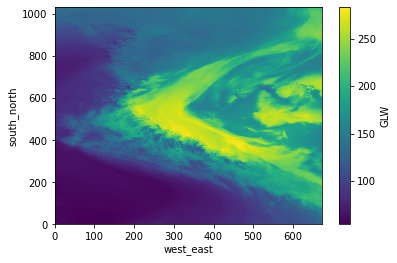

In [34]:
ds.GLW.mean(dim='Time').plot()
# ds.U.nbytes/1e6

In [35]:
outdir = os.path.join(gcsdir, ampsdir, amps_ver, domain, 'zarr-raw/')
# fs.glob(outdir)
fs.ls(outdir)

['ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/test_JK.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/test_JK2.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/test_JK3.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_JK.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_appendingTest.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_appendingTest2.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_appendingTest3.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_appendingTest4.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2D_rechunked_appendingTest5.zarr',
 'ldeo-glaciology/AMPS/WRF_24/domain_03/zarr-raw/wrfout_d03_201909_2Donly.zarr',


In [36]:
import json

with open('secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
# gcs = gcsfs.GCSFileSystem(token=token)

amps_mapper = fsspec.get_mapper(outdir + 'wrfout_d03_201909_2Donly_test_XTIME_v11.zarr', mode='ab',
                            token=token)

In [37]:
# %%time
# ds.to_zarr(amps_mapper, mode='w');

CPU times: user 6.48 s, sys: 594 ms, total: 7.07 s
Wall time: 8min 56s

In [38]:
AMPS_gsc_combined = xr.open_dataset(amps_mapper, engine='zarr')

In [39]:
AMPS_gsc_combined

<xarray.Dataset>
Dimensions:   (XTIME: 16, south_north: 1035, west_east: 675)
Coordinates:
    XLAT      (XTIME, south_north, west_east) float32 ...
    XLONG     (XTIME, south_north, west_east) float32 ...
  * XTIME     (XTIME) datetime64[ns] 2019-09-30T03:00:00 ... 2019-10-02
Dimensions without coordinates: south_north, west_east
Data variables: (12/23)
    ACSNOM    (XTIME, south_north, west_east) float32 ...
    GLW       (XTIME, south_north, west_east) float32 ...
    HFX       (XTIME, south_north, west_east) float32 ...
    HGT       (XTIME, south_north, west_east) float32 ...
    LANDMASK  (XTIME, south_north, west_east) float32 ...
    LH        (XTIME, south_north, west_east) float32 ...
    ...        ...
    SSTSK     (XTIME, south_north, west_east) float32 ...
    SWDOWN    (XTIME, south_north, west_east) float32 ...
    T2        (XTIME, south_north, west_east) float32 ...
    TSK       (XTIME, south_north, west_east) float32 ...
    U10       (XTIME, south_north, west_east) float32 ...
    V10       (XTIME, south_north, west_east) float32 ...
Attributes: (12/122)
    ADAPT_DT_MAX:                    17.0
    ADAPT_DT_MIN:                    8.0
    ADAPT_DT_START:                  9.0
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    ...                              ...
    WEST-EAST_PATCH_END_STAG:        676
    WEST-EAST_PATCH_END_UNSTAG:      675
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0

## Close your cluster, be a good denizen.

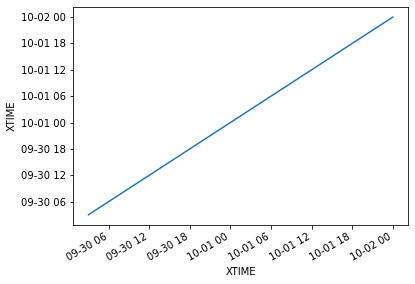

In [17]:
AMPS_gsc_combined.XTIME.plot()

In [26]:
AMPS_gsc_combined['T2'].chunk()

<xarray.DataArray 'T2' (XTIME: 16, south_north: 1035, west_east: 675)>
dask.array<xarray-<this-array>, shape=(16, 1035, 675), dtype=float32, chunksize=(16, 1035, 675), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (XTIME, south_north, west_east) float32 dask.array<chunksize=(16, 1035, 675), meta=np.ndarray>
    XLONG    (XTIME, south_north, west_east) float32 dask.array<chunksize=(16, 1035, 675), meta=np.ndarray>
  * XTIME    (XTIME) datetime64[ns] 2019-09-30T03:00:00 ... 2019-10-02
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    stagger:      
    units:        K

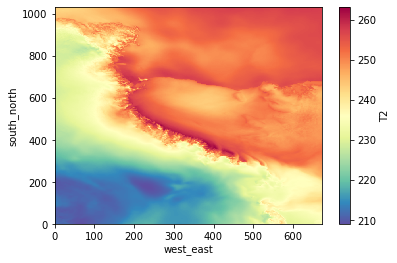

In [29]:
AMPS_gsc_combined['T2'].mean(dim='XTIME').plot(cmap='Spectral_r')

In [36]:
cluster.shutdown()